In [56]:
!nvidia-smi

Fri Sep 11 11:39:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |    929MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [124]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from torch.autograd import Variable
import torchvision
import seaborn as sns
import matplotlib
%matplotlib inline

In [74]:
class G(nn.Module):
    def __init__(self, ngf=64, nz=64):
        super().__init__()
        self.ngf = ngf
        self.nz = nz
        self.define_module()

    def define_module(self):
        ngf = self.ngf
        in_dim = self.nz
        self.fc = nn.Sequential(
            nn.Linear(in_dim, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True))

        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.to_rgb = TO_RGB_LAYER(ngf // 4)

    def forward(self, z_code):
        out_code = self.fc(z_code)
        out_code = out_code.view(-1, self.ngf, 4, 4)     # 64 * 4 * 4
        out_code = self.upsample1(out_code)              # 32 * 8 * 8
        out_code = self.upsample2(out_code)              # 16 * 16 * 16
        img = self.to_rgb(out_code)
        return img
    

class D(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.ndf = ndf
        self.define_module()

    def define_module(self):
        ndf = self.ndf
        self.from_rgb = fromRGB_layer(ndf // 4)
        self.downblock1 = downBlock_p(ndf // 4, ndf // 2, 3, 1, 1)
        self.downblock2 = downBlock_p(ndf // 2, ndf, 3, 1, 1)
#         self.downblock3 = downBlock_p(ndf * 2, ndf * 2, 3, 1, 1)
        self.uncond_logits = PartialConv2d(ndf, 1, kernel_size=4, stride=4)
    def forward(self, x_var, mask=None):
        """
        - x_var (tensor): 3x16x16
        - mask (tensor): 1x16x16
        """
        x_code = self.from_rgb(x_var)                 # 16 * 16 * 16
        x_code, mask = self.downblock1(x_code, mask)  # 32 * 8 * 8
        x_code, mask = self.downblock2(x_code, mask)  # 64 * 4 * 4
        rf_score, _ = self.uncond_logits(x_code, mask)
        rf_score = F.sigmoid(rf_score)
        return rf_score.view(-1)

In [157]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d):
        nn.init.orthogonal(m.weight.data, 1.0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.orthogonal(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
    elif classname == 'PartialConv':
        nn.init.constant_(m.mask_conv.weight.data, 1.0)

        
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.LeakyReLU(0.2, inplace=True))
    return block


class TO_RGB_LAYER(nn.Module):
    def __init__(self, ngf):
        super().__init__()
        self.gf_dim = ngf
        self.img = nn.Sequential(
            nn.Conv2d(ngf, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, h_code):
        out_img = self.img(h_code)
        return out_img

    
class PartialConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                 dilation=1, groups=1,bias=False):
        super().__init__()
        self.input_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv2d(
            1, 1, kernel_size, stride, padding, dilation, groups, False)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

        self.bias = self.input_conv.bias
        self.all = kernel_size * kernel_size
    def forward(self, input, mask=None):
        """
        input is regular tensor with shape N*C*H*W
        mask has to have 1 channel N*1*H*W

        mask: 0's for foreground
        """
        if mask is None:
            return self.input_conv(input), mask
        
        output = self.input_conv(input * mask)
        # get bias which will be used later
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            _frac = self.mask_conv(torch.ones_like(mask))
            mask = self.mask_conv(mask)

        no_update_holes = mask == 0
        mask_ratio = _frac / mask.masked_fill_(no_update_holes, 1.0)
        # mask_ratio = 1
        output_pre = (output - output_bias) * mask_ratio + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)
        new_mask = 1 - no_update_holes.float()
        return output, mask


class downBlock_p(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, 
                 dilation=1, groups=1, bias=False):
        super().__init__()
        self.conv = PartialConv2d(in_channels, out_channels,
            kernel_size, stride, padding, dilation, groups, bias)

    def forward(self, input, mask=None):
        """
        input is regular tensor with shape N*C*H*W
        mask has to have 1 channel N*1*H*W
        """
        global amflag
        output, mask = self.conv(input, mask)
        if amflag:
            amshow(input, output)
            amflag = False
        output = F.leaky_relu(output, 0.2, inplace=True)
        output = F.avg_pool2d(output, 2)
        if mask is not None:
            mask = F.avg_pool2d(mask, 2)
            no_update_holes = mask == 0
            mask = 1 - no_update_holes.float()
        return output, mask

    
def fromRGB_layer(out_planes):
    layer = nn.Sequential(
        nn.Conv2d(3, out_planes, 1, 1, 0, bias=False),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return layer

In [62]:
class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super(PartialConv2d, self).__init__(*args, **kwargs)

        self.multi_channel = False
        self.return_mask = True
        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])
            
        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in
                        
                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)

        if self.return_mask:
            return output, self.update_mask
        else:
            return output

In [63]:
def get_mask(imshape, bbox):
    """
    mask: 0's for foreground
    """
    c, r = imshape
    x1, y1, w, h = bbox
    x2 = x1 + w
    y2 = y1 + h
    mk = np.ones((r, c))
    mk[y1: y2 + 1, x1: x2 + 1] = 0
    return Image.fromarray(mk)

def train_img_gen(mask_size=-1):
    """
    - mask_size (int): -1: random mask
                       0 ~ imsize: fixed size
    """
    norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    imsize = 16
    img = 255 * np.concatenate((np.ones((imsize,imsize,1)), np.zeros((imsize,imsize,2))), axis=2).astype(np.uint8)
    if mask_size == -1:
        bbox = np.random.randint(0, imsize, 4)
        x1 = np.min(bbox[0: 2])
        x2 = np.max(bbox[0: 2])
        y1 = np.min(bbox[2: 4])
        y2 = np.max(bbox[2: 4])
    elif mask_size == 0:
        x1, y1, x2, y2 = 0, 0, -1, -1
    elif mask_size == imsize:
        x1, y1 = 0, 0
        x2, y2 = imsize-1, imsize-1
    else:
        bbox = np.random.randint(0, imsize-mask_size+1, 2)
        x1 = bbox[0]
        x2 = x1 + mask_size - 1
        y1 = bbox[1]
        y2 = y1 + mask_size - 1

    noise = torch.FloatTensor(3, imsize, imsize)
    noise.data.normal_(0, 1)
      
    img[y1: y2 + 1, x1: x2 + 1, 0] = 0
    img[y1: y2 + 1, x1: x2 + 1, 1] = 255
    # print(x1,y1,x2,y2)
    img = Image.fromarray(img)
    mk = torch.ones((1, imsize, imsize))
    mk[0, y1: y2 + 1, x1: x2 + 1] = 0
#     plt.hold()
#     plt.imshow(img)
#     plt.imshow(mk)
    img = torch.clamp(norm(img) + noise * 1e-1, -1, 1)

    return img, mk

In [64]:
def imshow(im):
    _im = torchvision.utils.make_grid(im, pad_value=-1).detach().cpu().numpy()
    _im = np.transpose(_im, (1, 2, 0))
    _im = (_im + 1) * 255 / 2
    _im = _im.astype(np.uint8)

    plt.imshow(_im)

In [65]:
def prepare_data(batch_size, mask_size):
    imsize = 16
    im_li = []
    mk_li = []
    for i in range(batch_size):
        im, mk = train_img_gen(mask_size)
        im = im.view(1, 3, imsize, imsize)
        # imshow(im)
        mk = mk.view(1, 1, imsize, imsize)
        im_li.append(im)
        mk_li.append(mk)
    ims = torch.cat(im_li, dim=0).cuda() 
    mks = torch.cat(mk_li, dim=0).cuda()
    return ims, mks

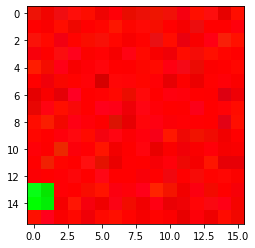

In [66]:
im, _ = prepare_data(1,2)
imshow(im[0])

In [97]:
nz = 64
ngf = 64
ndf = 64
batch_size = 16
mask_size = 5
# use regular convolution
reg_conv = False
amflag = True

In [158]:
netG = G(ngf, nz).cuda()
netD = D(ndf).cuda()
netG.apply(weights_init)
netD.apply(weights_init)
optD = optim.Adam(netD.parameters(),
                  lr=2e-4,
                  betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(),
                  lr=2e-4,
                  betas=(0.5, 0.999))
criterion_one = nn.BCELoss().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  after removing the cwd from sys.path.


In [171]:
def amshow(input, activation_maps):
    b, c, h, w = activation_maps.size()
    if b > 5:
        b = 5
    if c > 8:
        c = 8
    fs = 3
    fh = b * fs
    fw = c * fs
    fig, axs = plt.subplots(b, c + 1, figsize=(fw, fh))
    for b_i in range(b):
        im = input[b_i][0].detach().cpu().numpy()
        axs[b_i, 0].imshow(im, cmap='coolwarm')
        for c_i in range(c):
            am = activation_maps[b_i][c_i].detach().cpu().numpy()
            # sns.despine(left=True)
            # sns.heatmap(am, cmap='coolwarm', cbar=False, annot=False, fmt=".3f", ax=axes[b_i, c_i])
            axs[b_i, c_i + 1].imshow(am, cmap='coolwarm')
            # am = activation_maps[b]
            # ax.plot

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.5234, 0.4766, 0.5227, 0.5421, 0.5386, 0.4706, 0.4999, 0.5053, 0.4990,
        0.4760, 0.5300, 0.4695, 0.4860, 0.5217, 0.4736, 0.5243],
       device='cuda:0', grad_fn=<ViewBackward>)

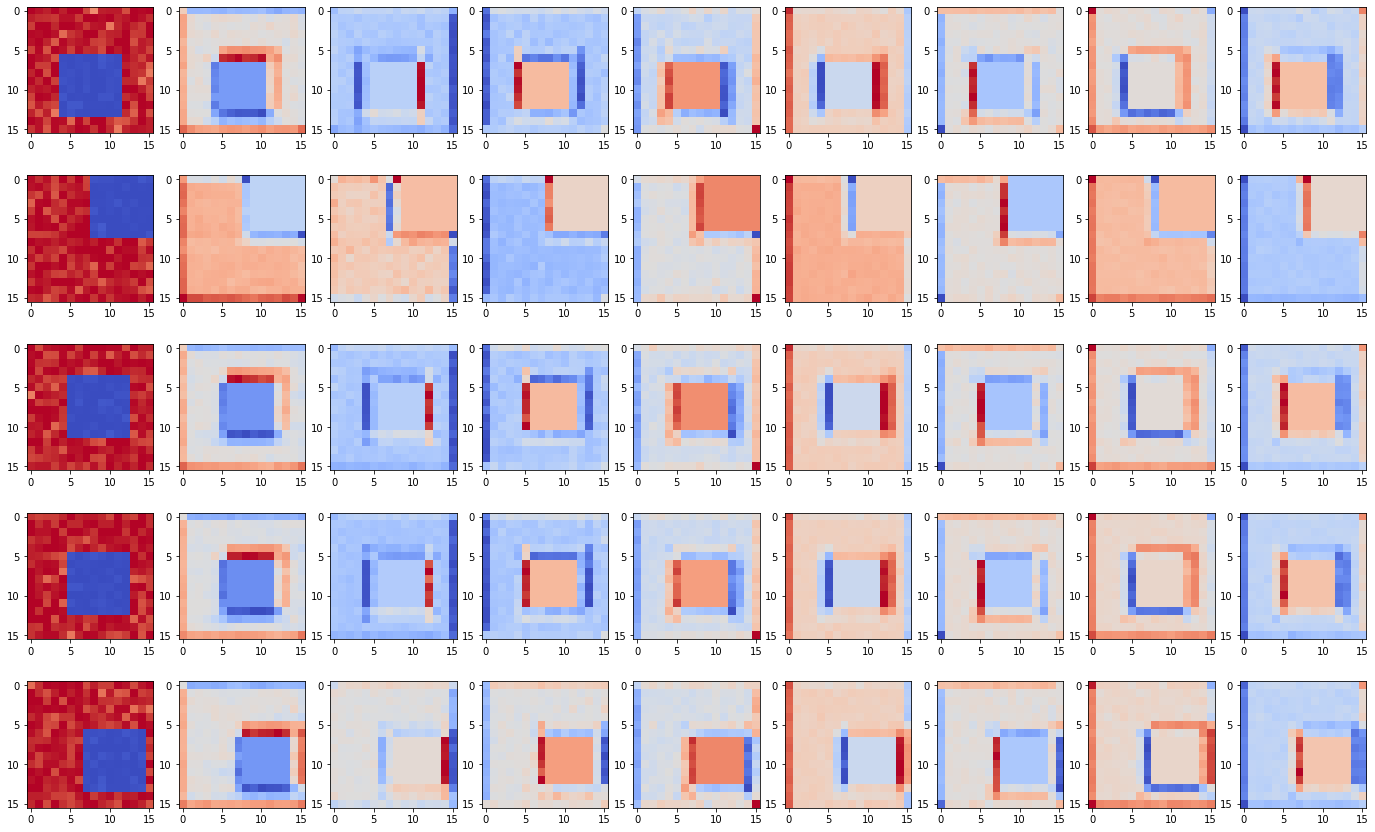

In [172]:
im, mk = prepare_data(batch_size, 8)
# imshow(im[0])
amflag = True
rfs = netD(im, mk)
rfs

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.5023, 0.5077, 0.5073, 0.5041, 0.5067, 0.5072, 0.5037, 0.5061, 0.5058,
        0.5039, 0.5025, 0.5068, 0.5053, 0.5066, 0.5034, 0.5061],
       device='cuda:0', grad_fn=<ViewBackward>)

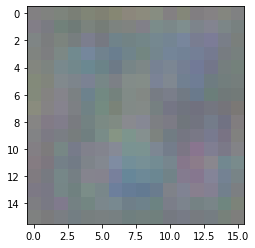

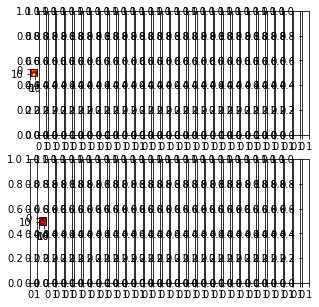

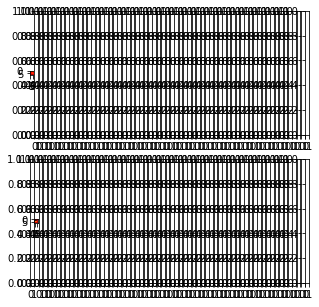

In [78]:
netG.eval()
_noise = Variable(torch.FloatTensor(batch_size, nz)).cuda()
_noise.data.normal_(0, 1)
imshow(netG(_noise)[0])
rfs = netD(netG(_noise))
rfs

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/10]Loss_D: 0.41 Loss_G: 1.12 Time: 1.71s
[2/10]Loss_D: 0.69 Loss_G: 0.84 Time: 1.79s
[3/10]Loss_D: 0.27 Loss_G: 1.54 Time: 1.76s
[4/10]Loss_D: 0.33 Loss_G: 1.33 Time: 1.87s
[5/10]Loss_D: 0.39 Loss_G: 1.15 Time: 1.79s
[6/10]Loss_D: 0.21 Loss_G: 1.75 Time: 1.84s
[7/10]Loss_D: 0.26 Loss_G: 1.25 Time: 2.02s
[8/10]Loss_D: 0.25 Loss_G: 1.74 Time: 1.68s
[9/10]Loss_D: 0.22 Loss_G: 1.69 Time: 1.69s
[10/10]Loss_D: 0.28 Loss_G: 1.55 Time: 1.67s


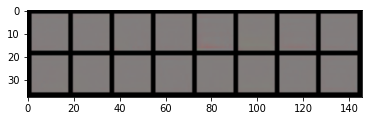

In [ ]:
max_count = 1001

ep = 0
netG.train()
start_t = time.time()
for count in range(1, max_count):
    ims, mks = prepare_data(batch_size, mask_size)
    if reg_conv:
        mks = None

    noise = Variable(torch.FloatTensor(batch_size, nz)).cuda()
    noise.data.normal_(0, 1)
    fake_ims = netG(noise)
    
    # train D    
    netD.zero_grad()
    real_logits, _ = netD(ims, mks)
    fake_logits, _ = netD(fake_ims.detach())
    fake_labels = torch.zeros_like(fake_logits)
    real_labels = torch.ones_like(real_logits)
    errD_real = criterion_one(real_logits, real_labels) # Real/Fake loss for the real image
    # print(errD_real)
    errD_fake = criterion_one(fake_logits, fake_labels) # Real/Fake loss for the fake image
    # print(errD_fake)
    errD = errD_real + errD_fake
    errD.backward()
    optD.step()
    
    # train G
    netG.zero_grad()
    netD.zero_grad()
    # _, mks = prepare_data(batch_size, -1)
    fake_logits, _ = netD(fake_ims)
    real_labels = torch.ones_like(fake_logits)
    errG = criterion_one(fake_logits, real_labels)
    errG.backward()
    optG.step()
    
    if count % 100 == 0:
        ep += 1
        end_t = time.time()
        print('[%d/%d]Loss_D: %.2f Loss_G: %.2f Time: %.2fs'
              % (ep, int(max_count/100),
                errD.item(), errG.item(),
                end_t - start_t))
        imshow(fake_ims)
        start_t = time.time()

In [ ]:
conv2d = PartialConv2d(3, 1, 3, 2, 0, bias=False)
conv = PartialConv(3, 1, 3, 2, 0, bias=False)
conv.input_conv.weight = conv2d.weight
nn.init.constant(conv.mask_conv.weight, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  after removing the cwd from sys.path.


Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [ ]:
L = nn.BCELoss()

In [ ]:
# x = torch.zeros(1)
x = torch.tensor([0.])
y = torch.ones(1)
print(x, y)
print(L(x, y))

tensor([0.]) tensor([1.])
tensor(100.)


In [ ]:
L(x, y)

tensor(100.)

In [ ]:
input = torch.ones(1,1,3,3)
kernel = torch.ones(1,1,3,3)
input[0,0,1:3,1:3] = 0
input

tensor([[[[1., 1., 1.],
          [1., 0., 0.],
          [1., 0., 0.]]]])

In [ ]:
F.conv2d(input, kernel)

tensor([[[[5.]]]])

In [ ]:
conv2d = PartialConv2d(1, 1, 3, 1, 0, bias=False)
nn.init.constant(conv2d.weight,1)
input = torch.ones(1,1,3,3)
mask = torch.ones(1,1,3,3)
mask[0,0,1:3,1:3] = 0
mask

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  


tensor([[[[1., 1., 1.],
          [1., 0., 0.],
          [1., 0., 0.]]]])

In [ ]:
conv2d(input, mask)

(tensor([[[[9.]]]], grad_fn=<MulBackward0>), tensor([[[[1.]]]]))

In [ ]:
conv2d(mask, input)

(tensor([[[[5.]]]], grad_fn=<MulBackward0>), tensor([[[[1.]]]]))

In [ ]:
fm = xcl[0][0][0].detach().cpu().numpy()

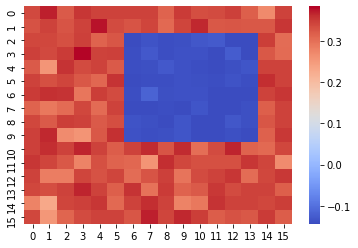

In [ ]:
sns.heatmap(fm, cmap='coolwarm')

In [ ]:
def vis_actmap(actmaps):
    _im = torchvision.utils.make_grid(actmaps, pad_value=-1).detach().cpu().numpy()
    print(_im.shape)
    sns.heatmap(_im, cmap='coolwarm')

    # plt.imshow(_im)

In [ ]:
vis_actmap(xcl[0])

(16, 38, 146)


ValueError: ignored

[[ 0.3395  0.3705  0.3238  0.3562  0.3465  0.3465  0.3465  0.3465  0.3157  0.351   0.3363  0.3367  0.3467  0.3187  0.2709  0.3465]
 [ 0.3315  0.3465  0.3292  0.3465  0.3775  0.3365  0.3302  0.3426  0.3077  0.3442  0.3673  0.3249  0.3271  0.324   0.3253  0.3564]
 [ 0.342   0.3418  0.3329  0.3481  0.3138  0.3278 -0.1439 -0.1353 -0.1406 -0.1391 -0.1306 -0.1273 -0.1421 -0.1427  0.3493  0.3048]
 [ 0.3482  0.34    0.3526  0.3838  0.3465  0.3476 -0.141  -0.1288 -0.141  -0.1364 -0.1372 -0.1422 -0.1245 -0.1434  0.3259  0.3071]
 [ 0.3239  0.2561  0.359   0.3383  0.3465  0.3232 -0.1418 -0.1392 -0.1289 -0.1368 -0.1398 -0.1423 -0.1392 -0.1319  0.3465  0.3465]
 [ 0.3465  0.3334  0.3445  0.3249  0.3116  0.358  -0.1429 -0.1403 -0.1403 -0.1365 -0.1394 -0.1407 -0.135  -0.1417  0.3632  0.3465]
 [ 0.3528  0.361   0.3588  0.2939  0.3489  0.3365 -0.1405 -0.1159 -0.1387 -0.1368 -0.1362 -0.142  -0.1421 -0.1439  0.3465  0.3557]
 [ 0.3145  0.2918  0.3065  0.3407  0.3075  0.3465 -0.1418 -0.1439 -0.1413 -0.1432 -

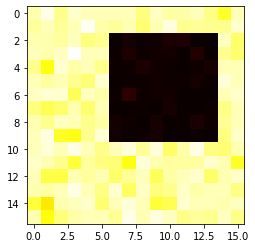

In [ ]:
plt.imshow(fm, cmap='hot')
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
print(fm)

In [ ]:
im, mk = prepare_data(batch_size, 5)
_, xcl = netD(im, mk)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


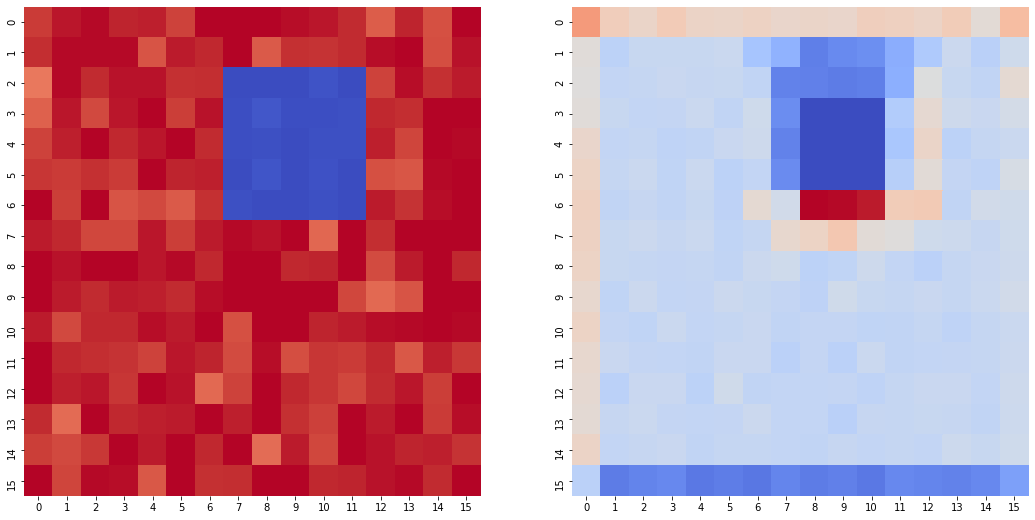

In [ ]:
fm1 = xcl[0][0][0][3].detach().cpu().numpy()
fm2 = xcl[0][1][0][2].detach().cpu().numpy()
# im = torch.ones(1,1,16,16)
# im.data.normal_(-1, 1)
# fm1 = im[0][0].numpy()
# conv2d = PartialConv2d(1, 1, 3, 1, 1, bias=False)
# nn.init.constant_(conv2d.weight.data, 1.0)
# print(conv2d.weight)
# fm2,_ = conv2d(xcl[0][0][0][0].view(1,1,16,16).cpu(), xcl[1][0][0][0].view(1,1,16,16).cpu())
# fm2 = fm2.detach().cpu().numpy()[0][0]
f, axes = plt.subplots(1, 2, figsize=(18, 9), sharex=True)
sns.despine(left=True)
sns.heatmap(fm1, cmap='coolwarm', cbar=False, annot=False, fmt=".3f", ax=axes[0])
sns.heatmap(fm2, cmap='coolwarm', cbar=False, annot=False, fmt=".3f", ax=axes[1])

In [ ]:
fm2.shape

(1, 1, 16, 16)

RuntimeError: ignored

In [ ]:
torch.mul(xcl[0][0][0][0], xcl[1][0][0][0])

tensor([[-0.1575, -0.1574, -0.1571, -0.1571, -0.1500, -0.1545, -0.1575, -0.1558,
         -0.1536, -0.1571, -0.1410, -0.1461, -0.1561, -0.1571, -0.1526, -0.1355],
        [-0.1609, -0.1519, -0.1550, -0.1476, -0.1534, -0.1583, -0.1593, -0.1502,
         -0.1571, -0.1436, -0.1487, -0.1501, -0.1571, -0.1577, -0.1524, -0.1477],
        [-0.1588, -0.1536, -0.1443, -0.1558, -0.1571, -0.1418, -0.1571, -0.1528,
         -0.1564, -0.1571, -0.1590, -0.1311, -0.1503, -0.1602, -0.1571, -0.1571],
        [-0.1571, -0.1350, -0.1496, -0.1501, -0.1585, -0.1504, -0.1581, -0.1467,
         -0.1319, -0.1372, -0.0293, -0.0288, -0.0204, -0.0116, -0.0145, -0.1404],
        [-0.1588, -0.1571, -0.1526, -0.1493, -0.1566, -0.1589, -0.1466, -0.1557,
         -0.1405, -0.1531, -0.0293, -0.0000, -0.0000, -0.0000, -0.0205, -0.1444],
        [-0.1533, -0.1581, -0.1454, -0.1582, -0.1547, -0.1506, -0.1534, -0.1605,
         -0.1452, -0.1570, -0.0223, -0.0000, -0.0000, -0.0000, -0.0188, -0.1571],
        [-0.1559, -0.1

In [ ]:
len(xcl)

2

In [90]:
def ttt():

  global amflag
  amflag = False

In [87]:
amflag

True

In [91]:
ttt()
amflag

False

In [146]:
9//8

1